Extration of the Metadata and the Images

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

file_path = "HAM10000 dataset/HAM10000_metadata.csv"
image_dirs = ["HAM10000 dataset/HAM10000_images_part_1", "HAM10000 dataset/HAM10000_images_part_2"]

# Check if metadata file exists
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"Metadata file not found at: {file_path}")
else:
    print(f"Metadata file found at: {file_path}")

# Load metadata
metadata = pd.read_csv(file_path)

# Check if each image directory exists
for image_dir in image_dirs:
    if not os.path.isdir(image_dir):
        raise FileNotFoundError(f"Image directory not found at: {image_dir}")
    else:
        print(f"Image directory found at: {image_dir}")

# Load image paths, check both directories
def get_image_path(image_id):
    for dir in image_dirs:  # Loop over image_dirs
        image_path = os.path.join(dir, image_id + ".jpg")
        if os.path.isfile(image_path):
            return image_path
    return None  # Return None if image is not found in any directory

metadata["image_path"] = metadata["image_id"].apply(get_image_path)

# Check if all images exist
missing_images = metadata[metadata["image_path"].isna()]
if not missing_images.empty:
    print(f"Missing images for the following image IDs:\n{missing_images['image_id'].tolist()}")
else:
    print("All images are accessible.")


Metadata file found at: HAM10000 dataset/HAM10000_metadata.csv
Image directory found at: HAM10000 dataset/HAM10000_images_part_1
Image directory found at: HAM10000 dataset/HAM10000_images_part_2
All images are accessible.


Exploring the Dataset and handeling the Missing Values

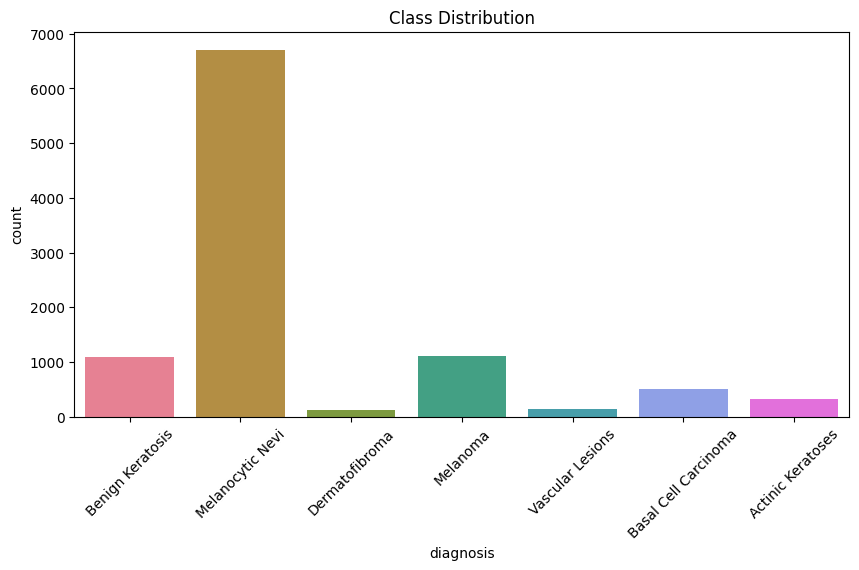

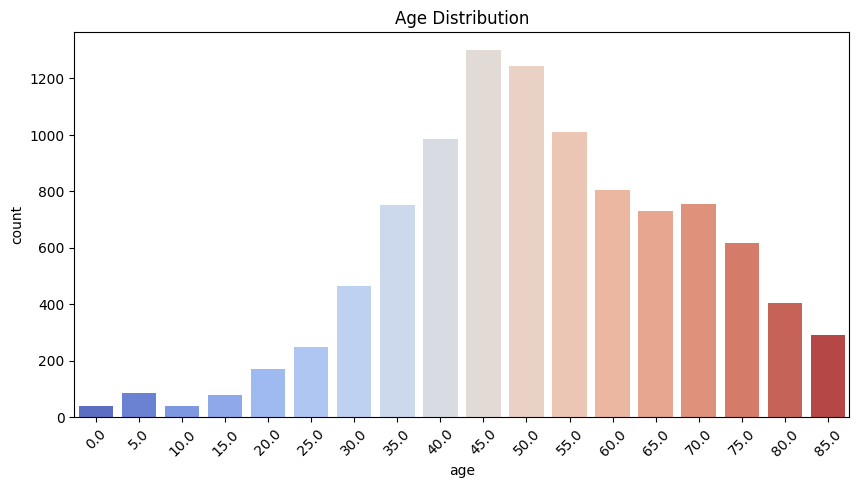

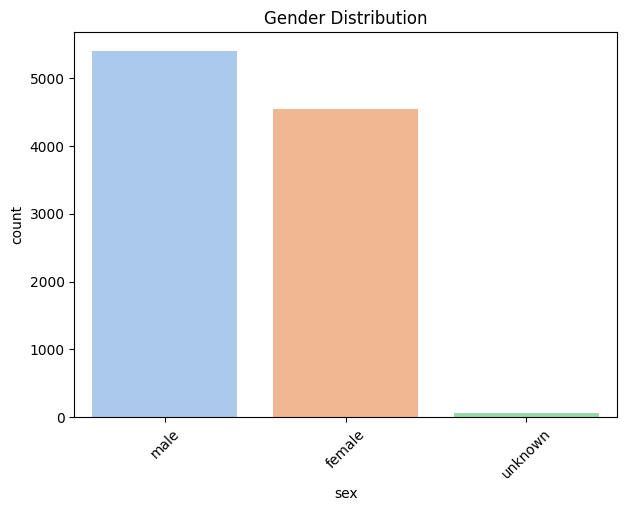

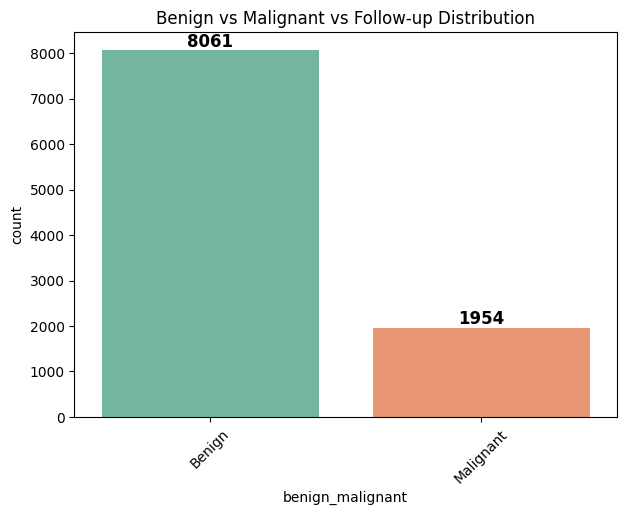

In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define target classes
class_mapping = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

# Map 'dx' to target classes
metadata["diagnosis"] = metadata["dx"].map(class_mapping)

#Handle missing values by filling them with default and median values
metadata["age"] = metadata["age"].fillna(metadata["age"].median())  # Fill missing age values with the median
metadata["sex"] = metadata["sex"].fillna("Unknown")  # Fill missing sex values with a default label
metadata["dx"] = metadata["dx"].fillna("Unknown")  # Fill missing diagnosis values with a default label


# Set color palettes
palette_class = sns.color_palette("husl", len(class_mapping))  # Different colors for diagnosis
palette_age = sns.color_palette("coolwarm", metadata['age'].nunique())  # Different colors for age
palette_sex = sns.color_palette("pastel")  # Different colors for gender
palette_bm = sns.color_palette("Set2")  # Different colors for benign/malignant

# Check class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=metadata["diagnosis"], palette=palette_class)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Check Age distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=metadata['age'], palette=palette_age)
plt.title("Age Distribution")
plt.xticks(rotation=45)
plt.show()

# Check for Gender distribution
plt.figure(figsize=(7, 5))
sns.countplot(x=metadata['sex'], palette=palette_sex)
plt.title("Gender Distribution")
plt.xticks(rotation=45)
plt.show()

# Check for Benign vs Malignant distribution
def categorize_case(dx):
    if dx in ['nv', 'bkl', 'df', 'vasc']:
        return "Benign"
    elif dx in ['mel', 'bcc', 'akiec']:
        return "Malignant"
    else:
        return "Follow-up"

metadata["benign_malignant"] = metadata["dx"].apply(categorize_case)

# Plot Benign vs Malignant vs Follow-up distribution
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=metadata["benign_malignant"], palette=palette_bm)
plt.title("Benign vs Malignant vs Follow-up Distribution")
plt.xticks(rotation=45)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.show()


Image Pre-Processing 

Processed images shape: (10015, 224, 224, 3)
One-hot encoded labels shape: (10015, 7)


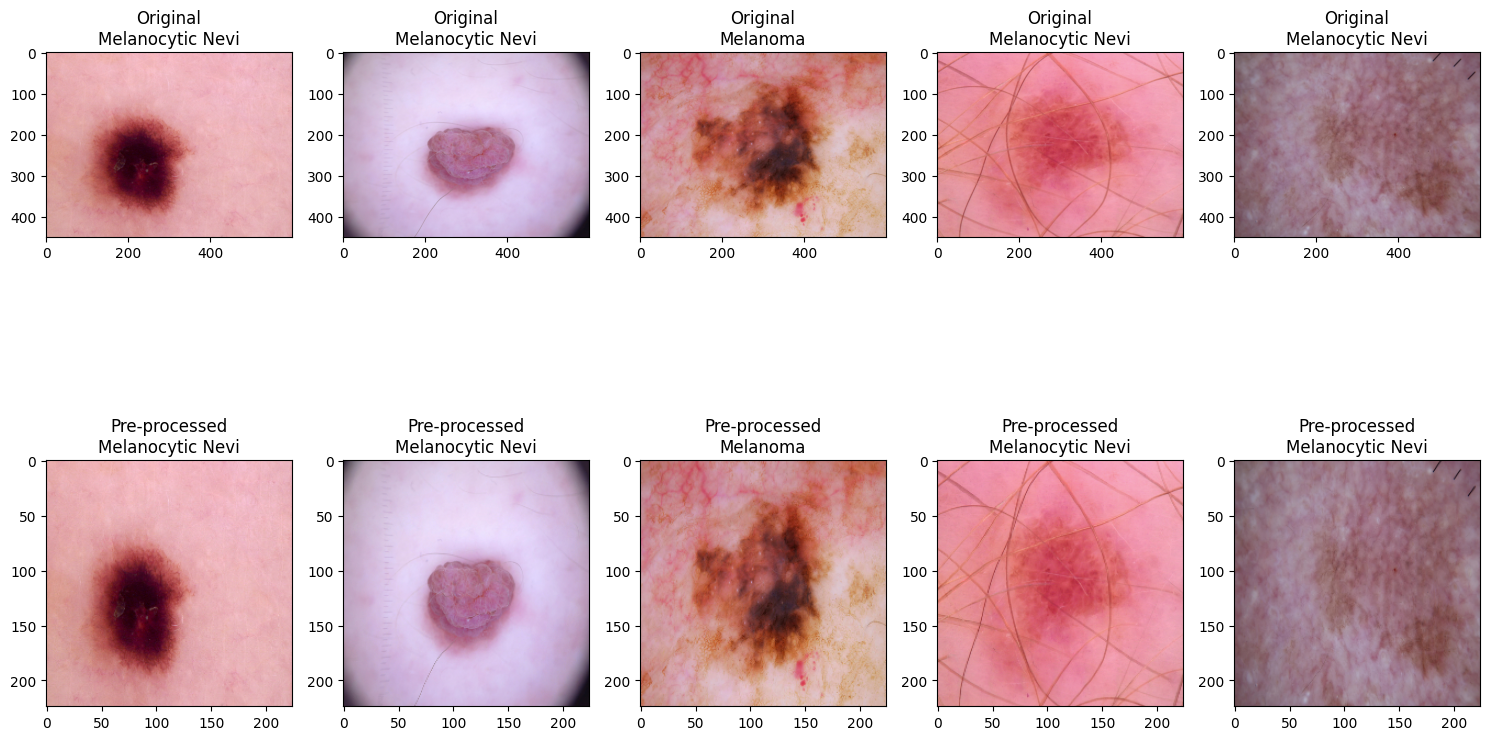

In [7]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tensorflow.keras.utils import to_categorical
import random
import matplotlib.pyplot as plt
import cv2

warnings.filterwarnings("ignore")

# Define the target image size for the model
target_size = (224, 224)

# Preprocess images and normalize them
def preprocess_image(image_path, target_size=(224, 224)):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize pixel values to be between 0 and 1
    image = image.astype("float32") / 255.0
    
    return image

# Apply preprocessing to all images and store them in a list
images = []
valid_image_paths = []

for image_path in metadata["image_path"]:
    image = preprocess_image(image_path, target_size)
    if image is not None:
        images.append(image)
        valid_image_paths.append(image_path)

# Convert the list of images to a NumPy array
images = np.array(images)

# Convert labels to categorical (one-hot encoding) for multi-class classification
labels = metadata["diagnosis"].map(class_mapping).values
labels = pd.Categorical(labels, categories=list(class_mapping.values()))  # Ensure correct ordering
labels = to_categorical(labels.codes, num_classes=len(class_mapping))

# Output the shapes of the processed images and labels
print(f"Processed images shape: {images.shape}")
print(f"One-hot encoded labels shape: {labels.shape}")

# Function to load the original images (without pre-processing)
def load_original_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        # Convert from BGR (OpenCV default) to RGB for correct color representation in matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Select a random sample of images and labels
sample_indices = random.sample(range(len(images)), 5)  # Display 5 random samples

# Plot the random sample of images with their respective labels (both processed and original)
plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    # Display original image
    original_image = load_original_image(metadata["image_path"].iloc[idx])
    plt.subplot(2, 5, i+1)
    plt.imshow(original_image)  # Display the original image
    plt.title(f"Original\n{metadata['diagnosis'].iloc[idx]}")  # Title with the label
    
    # Display pre-processed image
    plt.subplot(2, 5, i+6)
    plt.imshow(images[idx])  # Display the pre-processed image
    plt.title(f"Pre-processed\n{metadata['diagnosis'].iloc[idx]}")  # Title with the label

plt.tight_layout()
plt.show()




        Class Weighting 
    

In [13]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Map the labels using the class_mapping dictionary
labels = metadata["diagnosis"].values  # Get diagnosis labels

# Convert string labels to numerical labels
encoded_labels, unique_classes = pd.factorize(labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)

# Create a dictionary mapping class indices to weights
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Output the class weights
print(f"Class weights: {class_weight_dict}")



Class weights: {0: 1.301832835044846, 1: 0.21338020666879728, 2: 12.440993788819876, 3: 1.2854575792581184, 4: 10.075452716297788, 5: 2.78349082823791, 6: 4.375273044997815}


Image Augmentation

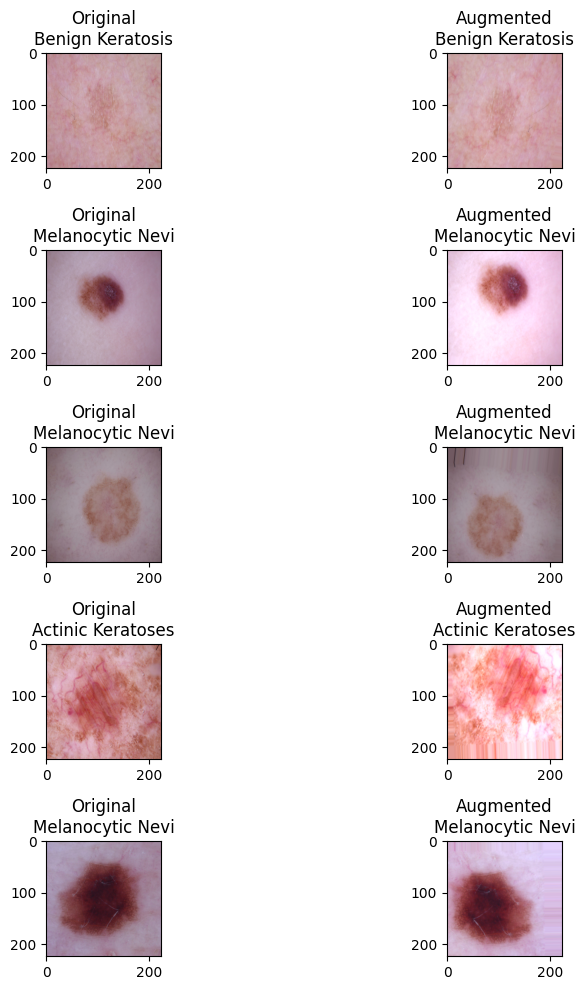

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Initialize the ImageDataGenerator for augmentations
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[1.0, 1.5],  # Adjust brightness range to avoid extreme dark images
    fill_mode='nearest',
)

# Select a random sample of images to apply augmentations
sample_indices = random.sample(range(len(images)), 5)  # Display 5 random samples

# Prepare the plot with adjusted size
plt.figure(figsize=(10, 10))

for i, idx in enumerate(sample_indices):
    original_image = images[idx]
    
    # Ensure original image is in range [0, 255]
    if original_image.max() <= 1:
        original_image = (original_image * 255).astype(np.uint8)
    
    original_image_expanded = np.expand_dims(original_image, axis=0)
    augmented_image = next(datagen.flow(original_image_expanded, batch_size=1))[0]
    
    # Ensure augmented image is correctly scaled and in uint8 format
    augmented_image = np.clip(augmented_image, 0, 255).astype(np.uint8)
    
    # Display the original image
    plt.subplot(5, 2, i*2+1)  # 5 rows, 2 columns
    plt.imshow(original_image)
    plt.title(f"Original\n{metadata['diagnosis'].iloc[idx]}")
    
    # Display the corresponding augmented image
    plt.subplot(5, 2, i*2+2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented\n{metadata['diagnosis'].iloc[idx]}")

plt.tight_layout()
plt.show()


Spliting into Training and Validation Sets (80% Training and 20% Validation)

In [35]:
from sklearn.model_selection import train_test_split

# Check if augmented images exist before splitting
if len(augmented_image) == 0:
    raise ValueError("No augmented images generated. Check augmentation settings or input data.")

# Split only the augmented images (labels remain linked to the images)
X_train, X_test = train_test_split(
    augmented_image, test_size=0.2, random_state=40, shuffle=True
)

# Print dataset shapes
print(f"Training images: {X_train.shape}")
print(f"Testing images: {X_test.shape}")


Training images: (179, 224, 3)
Testing images: (45, 224, 3)


        Test of Segmentation with Augmentation

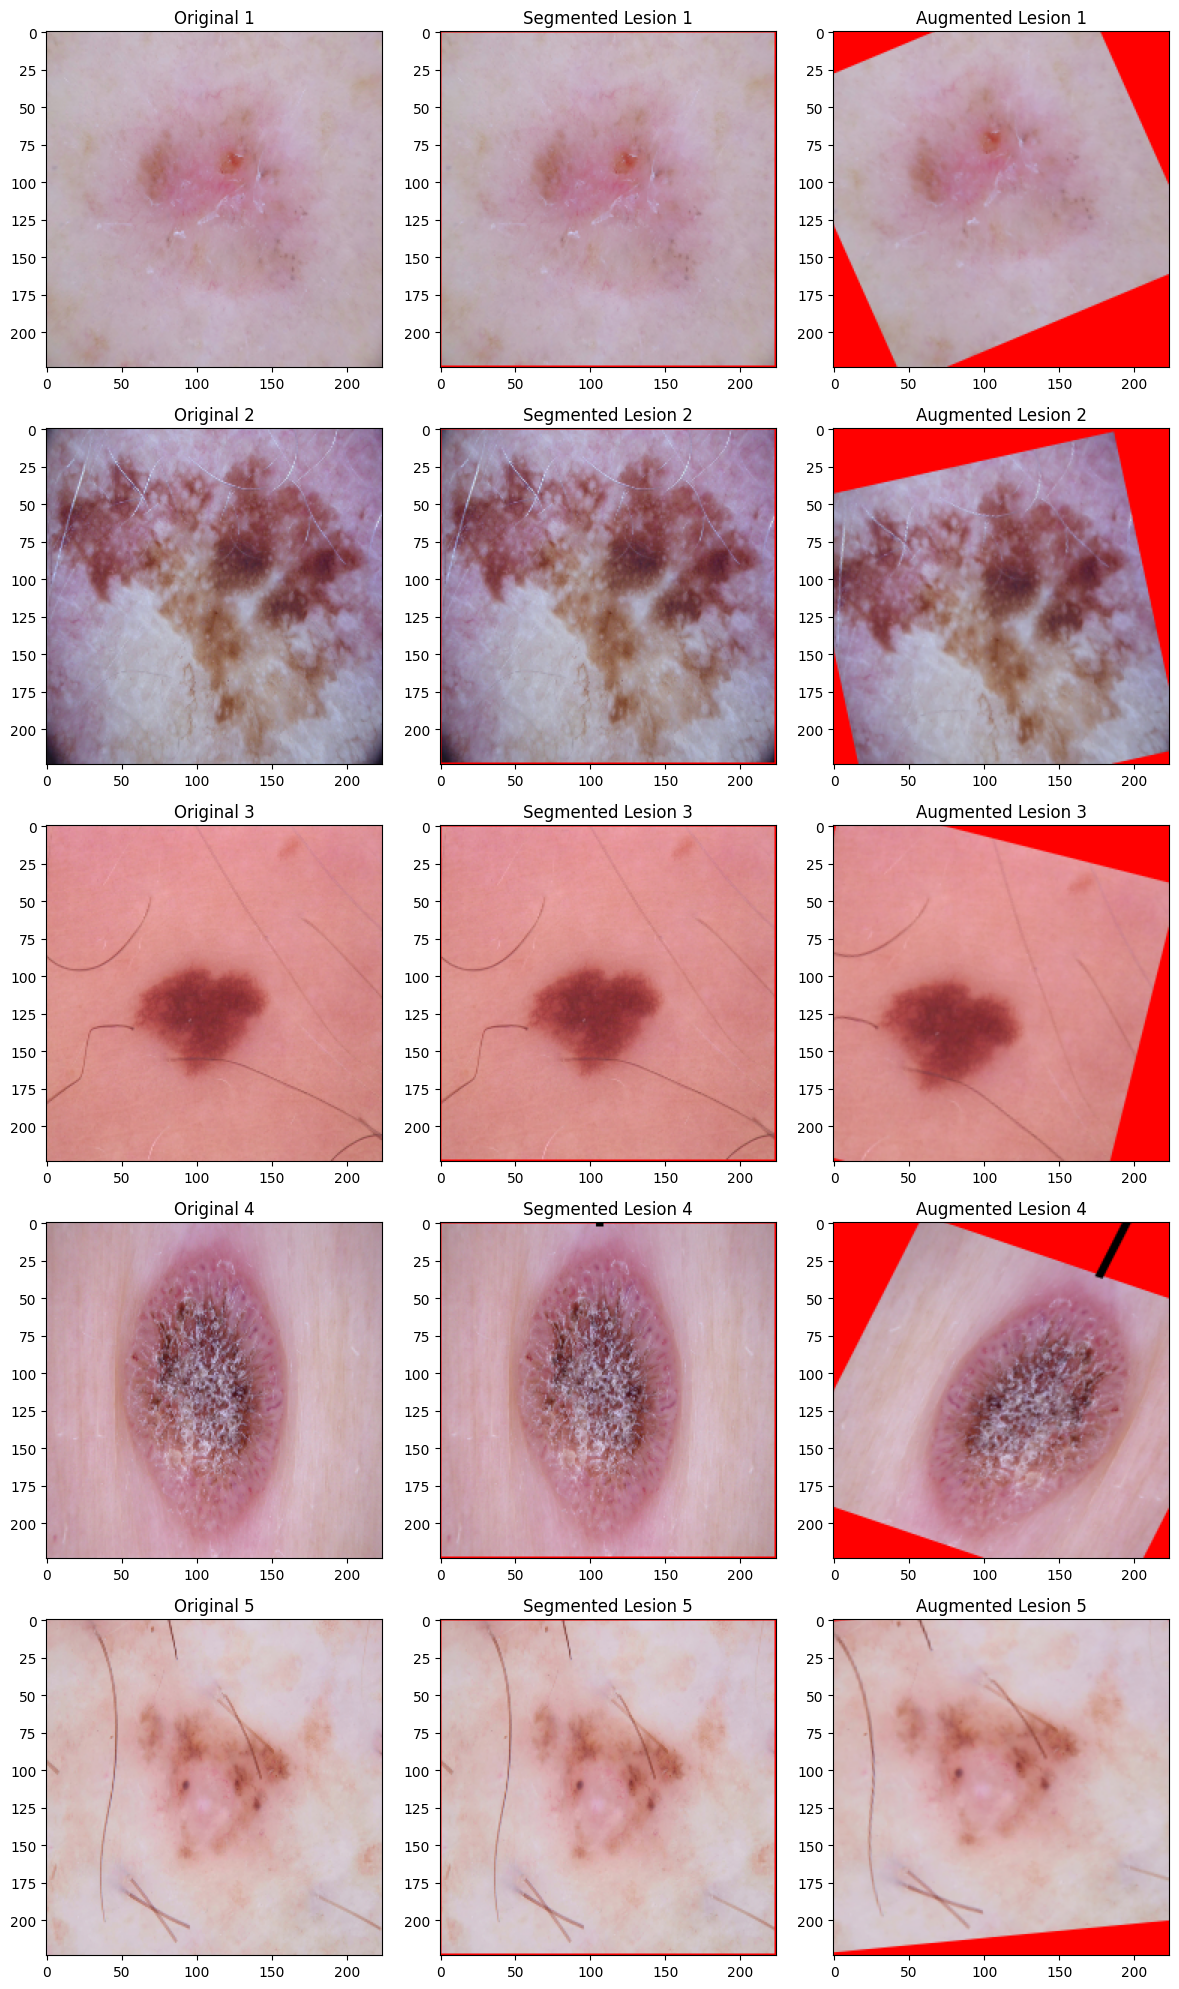

In [10]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def segment_lesion(image):
    """Segment the lesion with enhanced precision using advanced techniques."""
    
    # Image is in the range [0, 255] and convert to uint8
    image = (image * 255).astype(np.uint8)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization) for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # Apply median blur to remove noise while preserving edges
    blurred = cv2.medianBlur(gray, 5)

    # Use adaptive thresholding for better segmentation in varying light conditions
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)

    # Use Canny edge detection to capture lesion boundaries
    edges = cv2.Canny(thresh, 100, 200)

    # Apply dilation to strengthen edges and fill small gaps in the contours
    dilated_edges = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=2)

    # Watershed algorithm to refine boundaries and separate connected lesions
    ret, markers = cv2.connectedComponents(dilated_edges)
    markers = markers + 1  # Make sure all markers are positive
    markers[markers == 1] = 0  # Background marked as 0
    cv2.watershed(image, markers)

    # Mark watershed boundaries
    image[markers == -1] = [255, 0, 0]  # Mark boundaries in red for visualization
    
    # Find contours based on the refined edges (after watershed)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None, None  # No lesion found
    
    # Filter out small contours based on area
    contours = [contour for contour in contours if cv2.contourArea(contour) > 1000]  # Area threshold
    
    if not contours:
        return None, None  # No sufficiently large contours
    
    # Select the largest contour (assumed to be the lesion)
    lesion_contour = max(contours, key=cv2.contourArea)

    # Create a precise lesion mask
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [lesion_contour], -1, 255, thickness=cv2.FILLED)

    # Refine the mask using morphological operations
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)  # Close gaps

    # Extract the lesion by applying the refined mask
    segmented_lesion = cv2.bitwise_and(image, image, mask=refined_mask)

    return segmented_lesion, refined_mask


def apply_augmentation(segmented_lesion):
    """Apply augmentation directly to the extracted lesion area."""
    # Expand dimensions for ImageDataGenerator
    lesion_expanded = np.expand_dims(segmented_lesion, axis=0)

    # Augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=25,  # Rotation limited to avoid distortion
        zoom_range=0.2,  # Slight zoom
        width_shift_range=0.1,  # Controlled shifting
        height_shift_range=0.1,  
        shear_range=0.15,  # Gentle shearing
        horizontal_flip=True,  
        fill_mode='nearest'  # Keep structure intact
    )

    # Generate augmented lesion
    augmented_lesion = next(datagen.flow(lesion_expanded, batch_size=1))[0]

    # Ensure valid pixel values
    augmented_lesion = np.clip(augmented_lesion, 0, 255).astype(np.uint8)

    return augmented_lesion


# Number of samples to display
num_samples = 5

# Generate random indices for the images
random_indices = random.sample(range(len(images)), num_samples)

plt.figure(figsize=(12, num_samples * 4))

for i, idx in enumerate(random_indices):
    # Use pre-processed image from the random indices
    original_image = images[idx]  # Fetch pre-processed image from dataset

    # Segment lesion
    segmented_lesion, mask = segment_lesion(original_image)

    if segmented_lesion is not None:
        # Apply augmentation to the segmented lesion
        augmented_lesion = apply_augmentation(segmented_lesion)

        # Display results
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(original_image)
        plt.title(f"Original {i+1}")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(segmented_lesion)
        plt.title(f"Segmented Lesion {i+1}")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(augmented_lesion)
        plt.title(f"Augmented Lesion {i+1}")

plt.tight_layout()
plt.show()






        Using U-Net for the image Segmentation

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3), num_classes=1):
    inputs = layers.Input(input_size)
    
    # Contracting path (Encoder)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    
    # Expansive path (Decoder)
    up6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv7)
    concat8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv8)
    concat9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    # Output layer for segmentation
    if num_classes == 1:  # Binary segmentation (lesion vs background)
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)  # Output 1 channel with sigmoid
    else:  # Multi-class segmentation (multiple lesion classes)
        outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv9)  # Output channels with softmax

    model = models.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Example usage for binary segmentation (lesion vs background)
model = unet_model(input_size=(256, 256, 3), num_classes=1)  # For binary segmentation
model.summary()





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  4,719,104 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'images' already contains your augmented images


# Define ImageDataGenerator for image augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[1.0, 1.5],  # Adjust brightness range to avoid extreme dark images
    fill_mode='nearest',
)

# Define a function to augment both images and masks (for segmentation)
def augment_images_and_masks(images, masks, datagen):
    # Create a batch generator for image augmentations
    image_generator = datagen.flow(images, batch_size=1, seed=42)
    mask_generator = datagen.flow(masks, batch_size=1, seed=42)

    while True:
        # Get the next augmented image and mask
        augmented_image = next(image_generator)
        augmented_mask = next(mask_generator)
        
        # Return the augmented image and mask as a tuple
        yield augmented_image[0], augmented_mask[0]

# Now, let's compile and train the model using the augmented data
model = unet_model(input_size=(256, 256, 3), num_classes=1)

# Fit the model with augmented data
model.fit(
    augment_images_and_masks(images, mask, datagen),  # Generator for augmented data
    steps_per_epoch=len(images),  # Steps per epoch (based on the number of images)
    epochs=20  # Number of epochs
)




NameError: name 'unet_model' is not defined